In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

print("All libraries imported successfully!")


All libraries imported successfully!


In [61]:
df = pd.read_csv("../data/reviews.csv")

df = df[['text_', 'rating', 'category', 'label']]

print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns)

df.head()

Dataset Shape: (40432, 4)

Column Names:
Index(['text_', 'rating', 'category', 'label'], dtype='object')


,text_,rating,category,label
0,"Love this! Well made, sturdy, and very comfor...",5.0,Home_and_Kitchen_5,CG
1,"love it, a great upgrade from the original. I...",5.0,Home_and_Kitchen_5,CG
2,This pillow saved my back. I love the look and...,5.0,Home_and_Kitchen_5,CG
3,"Missing information on how to use it, but it i...",1.0,Home_and_Kitchen_5,CG
4,Very nice set. Good quality. We have had the s...,5.0,Home_and_Kitchen_5,CG


In [62]:
df['label'] = df['label'].map({'CG': 0, 'OR': 1})

df = df.dropna(subset=['label'])

print(df['label'].value_counts())


label
0    20216
1    20216
Name: count, dtype: int64


In [63]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df['clean_text'] = df['text_'].astype(str).apply(clean_text)

df[['text_', 'clean_text']].head()


,text_,clean_text
0,"Love this! Well made, sturdy, and very comfor...",love this well made sturdy and very comfortab...
1,"love it, a great upgrade from the original. I...",love it a great upgrade from the original ive...
2,This pillow saved my back. I love the look and...,this pillow saved my back i love the look and ...
3,"Missing information on how to use it, but it i...",missing information on how to use it but it is...
4,Very nice set. Good quality. We have had the s...,very nice set good quality we have had the set...


In [64]:
X = df[['clean_text', 'rating', 'category']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=5000, ngram_range=(1, 2)), 'clean_text'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['category']),
        ('num', 'passthrough', ['rating'])
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed.shape, X_test_processed.shape

((32345, 5011), (8087, 5011))

In [65]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_processed, y_train)

y_pred_lr = lr.predict(X_test_processed)

accuracy_score(y_test, y_pred_lr)

0.9265487819957957

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      4044
           1       0.92      0.94      0.93      4043

    accuracy                           0.93      8087
   macro avg       0.93      0.93      0.93      8087
weighted avg       0.93      0.93      0.93      8087



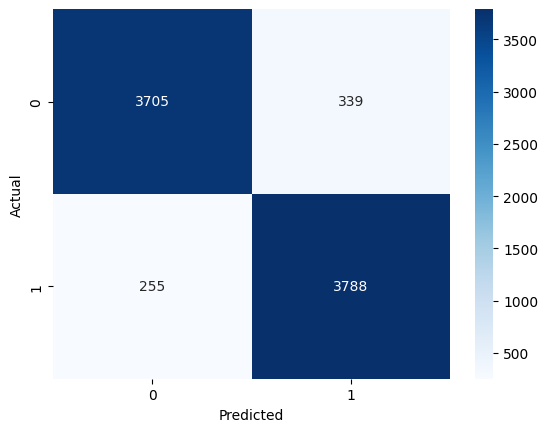

In [66]:
print(classification_report(y_test, y_pred_lr))

cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [67]:
svm = LinearSVC()
svm.fit(X_train_processed, y_train)

y_pred_svm = svm.predict(X_test_processed)

accuracy_score(y_test, y_pred_svm)

0.9296401632249289

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4044
           1       0.93      0.93      0.93      4043

    accuracy                           0.93      8087
   macro avg       0.93      0.93      0.93      8087
weighted avg       0.93      0.93      0.93      8087



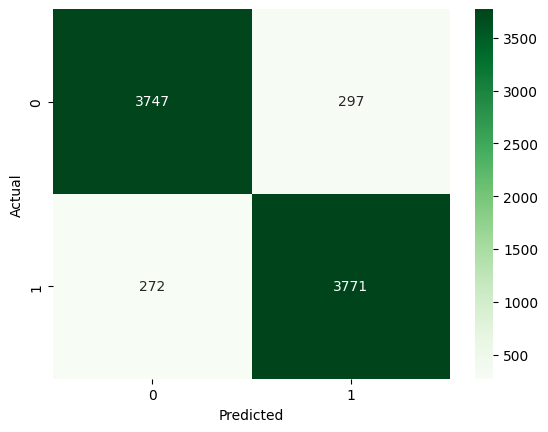

In [68]:
print(classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [69]:
results = pd.DataFrame({
    "Model": [
        "Logistic Regression (Text + Rating + Category)",
        "Linear SVM (Text + Rating + Category)"
    ],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_svm)
    ]
})

results


,Model,Accuracy
0,Logistic Regression (Text + Rating + Category),0.926549
1,Linear SVM (Text + Rating + Category),0.929640


In [70]:
import joblib

svm_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", lr)
    ]
)

joblib.dump(svm_pipeline, "../models/fake_review_hybrid_model.pkl")

"Hybrid fake review model saved successfully"

'Hybrid fake review model saved successfully'